In [76]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, precision_score, roc_auc_score, recall_score, average_precision_score

from tqdm import tqdm

In [77]:
y_train = pd.read_csv('../fraud_detection/active_datasets/y_train.csv', header=None).to_numpy().ravel()
y_test = pd.read_csv('../fraud_detection/active_datasets/y_test.csv', header=None).to_numpy().ravel()

In [78]:
X_train = pd.read_csv('../fraud_detection/active_datasets/original_paper_features_train.csv').to_numpy()
X_test = pd.read_csv('../fraud_detection/active_datasets/original_paper_features_test.csv').to_numpy()

In [79]:
def score(y_pred, y_true):
        scores = {}
        evaluation_funcs = {'accuracy':accuracy_score, 'precision':precision_score, 'recall':recall_score, 'f1':f1_score, 'MCC':matthews_corrcoef}
        for name, score in evaluation_funcs.items():
                scores[name] = score(y_pred = y_pred, y_true = y_true)
        scores['ROC-AUC'] = roc_auc_score(y_score = y_pred, y_true = y_true)
        scores['AUPR'] = average_precision_score(y_score = y_pred, y_true = y_true)

        return np.array(list(scores.values()))

In [80]:
def build_lof(X, y, k):
    LOF = LocalOutlierFactor(n_neighbors = k, contamination=sum(y_train)/len(y_train))
    y_pred = LOF.fit_predict(X)
    y_pred = list(map(lambda x: {-1:1, 1:0}[x], y_pred))
    return score(y_pred=y_pred, y_true=y)

In [81]:
def find_best_nneighbors(X, y, k_max):
    start, stop, step = 1, k_max + 1, k_max//10
    scores = {}
    while True:
        max_scores, max_k = 0, 0
        for i in (pbar := tqdm(range(start, stop, step))):
            pbar.set_description(f'k = {i}, step = {step}')
            scores[i] = build_lof(X, y, i)
            if (new_avg := np.mean(scores[i])) > max_scores:
                max_scores = new_avg
                max_k = i 
        start = max_k - 2 * step
        stop = max_k + 2 * step
        if step == 1:
            break
        step = (stop - start) // 10
    return scores

In [82]:
scores = find_best_nneighbors(X_test, y_test, 4000)

k = 2559, step = 1: 100%|██████████| 16/16 [43:48<00:00, 164.27s/it]


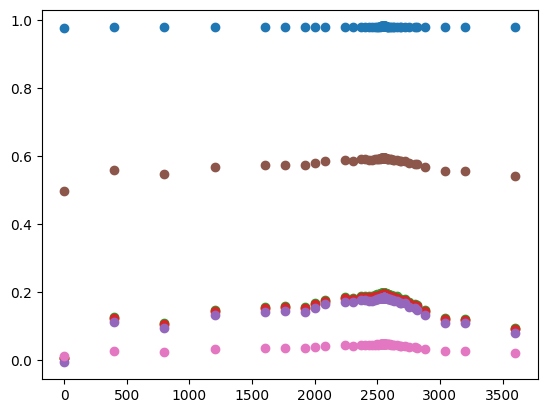

In [83]:
xs = list(scores.keys())
ys = list(scores.values())
for i in range(len(ys[0])):
    plt.scatter(xs, [y[i] for y in ys])